<a href="https://colab.research.google.com/github/u1tramax/hands-on-ml/blob/main/ods-classic-ml/02_%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Логистическая регрессия. Метрики качества**

## **Подготовка для работы в Google Colab или Kaggle**

#### Код для подключения Google Drive в Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Код для получения пути к файлам в Kaggle

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#### Код для установки библиотек

In [3]:
%pip install scipy==1.16.3 numpy==2.0.2 pandas==2.2.2 scikit-learn==1.6.1 statsmodels==0.14.6 matplotlib==3.10.0 seaborn==0.13.2

## **Важная информация**

**Для правильного воспроизведения результатов** решения задач:

* Рекомендуется придерживаться имеющего в заданиях кода в исходной последовательности. Для этого при решении задач **восстановите недостающие фрагменты кода, которые отмечены символом** `...` (Ellipsis).

* Если класс, функция или метод предусматривает параметр random_state, всегда указывайте **random_state=RANDOM_STATE**.

* Для всех параметров (кроме random_state) класса, функции или метода **используйте значения по умолчанию, если иное не указано в задании**.

**Если скорость обучения слишком низкая**, рекомендуется следующее:

* В модели или/и GridSearchCV поменяйте значение параметра n_jobs, который отвечает за параллелизм вычислений.

* Воспользуйтесь вычислительными ресурсами Google Colab или Kaggle.

***Использовать GPU не рекомендуется, поскольку результаты обучения некоторых моделей могут отличаться на CPU и GPU.***

После выполнения каждого задания **ответьте на вопросы в тесте.**

**ВНИМАНИЕ:** **После каждого нового запуска ноутбука** перед тем, как приступить к выполнению заданий, проверьте настройку виртуального окружения, выполнив код в ячейке ниже.

In [4]:
# Код для проверки настройки виртуального окружения

import sys
from importlib.metadata import version

required = {
    'python': '3.12.x',
    'scipy': '1.16.3',
    'numpy': '2.0.2',
    'pandas': '2.2.2',
    'scikit-learn': '1.6.1',
    'statsmodels': '0.14.6',
    'matplotlib': '3.10.0',
    'seaborn': '0.13.2'
}

print(f'{"Компонент":<15} | {"Требуется":<12} | {"Установлено":<12} | {"Соответствие"}')
print('-' * 62)

environment_ok = True
for lib, req_ver in required.items():
    try:
        if lib=='python':
            inst_ver = sys.version.split()[0]
            status = '✓' if sys.version_info.major == 3 and sys.version_info.minor == 12 else f'x (требуется {req_ver})'
        else:
            inst_ver = version(lib)
            if inst_ver == req_ver:
                status = '✓'
            else:
                environment_ok = False
                status = f'x (требуется {req_ver})'
    except:
        environment_ok = False
        inst_ver = '-'
        status = 'x (не установлена)'
    print(f'{lib:<15} | {req_ver:<12} | {inst_ver:<12} | {status:<12}')

print('\nРезультат проверки: ',
      '✓\nВсе версии соответствуют требованиям'
      if environment_ok else
      'x\nВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!\n'
      'Для решения проблемы обратитесь к инструкции по настройке виртуального окружения')

Компонент       | Требуется    | Установлено  | Соответствие
--------------------------------------------------------------
python          | 3.12.x       | 3.12.12      | ✓           
scipy           | 1.16.3       | 1.16.3       | ✓           
numpy           | 2.0.2        | 2.0.2        | ✓           
pandas          | 2.2.2        | 2.2.2        | ✓           
scikit-learn    | 1.6.1        | 1.6.1        | ✓           
statsmodels     | 0.14.6       | 0.14.6       | ✓           
matplotlib      | 3.10.0       | 3.10.0       | ✓           
seaborn         | 0.13.2       | 0.13.2       | ✓           

Результат проверки:  ✓
Все версии соответствуют требованиям


## **Импорт библиотек и вспомогательные функции**

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [7]:
RANDOM_STATE = 42

In [8]:
def ece_score(y_true, y_score, n_bins=10):
    """
    Возвращает значение метрики ECE для предсказанных вероятностей.
    Для расчета ECE используется метод равномерного (uniform) распределения бинов (интервалы бинов имеют равную длину).

    Аргументы:
        y_true (numpy.ndarray): Истинные значения целевой переменной.
        y_score (numpy.ndarray): Предсказанные вероятности целевого класса.
        n_bins (int): Количество бинов. По умолчанию — 10.

    Возвращает:
        float: Значение метрики ECE для предсказанных вероятностей.
    """
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_score, bins, right=True)
    ece = 0.0
    for i in range(1, n_bins + 1):
        bin_mask = (bin_indices == i)
        bin_size = bin_mask.sum()
        if bin_size > 0:
            bin_confidence = y_score[bin_mask].mean()
            bin_accuracy = y_true[bin_mask].mean()
            ece += (bin_size / len(y_true)) * abs(bin_accuracy - bin_confidence)
    return ece

## **Практическая часть**

### **Градиентный спуск**

Градиентный спуск (Gradient Descent) — это итерационный алгоритм численной оптимизации, используемый для нахождения локального минимума дифференцируемой функции. В контексте машинного обучения этой функцией является функция потерь (Loss Function), которая количественно оценивает ошибку модели.

Алгоритм градиентного спуска основан на свойстве градиента многомерной функции. Пусть $J$ — дифференцируемая функция, $\theta$ — вектор параметров функции. Тогда:

* Градиент $\nabla J(\theta)$, — это вектор, который указывает направление наискорейшего возрастания функции.

* Антиградиент $-\nabla J(\theta)$ — это вектор, который указывает направление наискорейшего убывания функции.

**Алгоритм градиентного спуска (для функции потерь $J(\theta)$):**

1. Инициализация. Выбирается начальное приближение для вектора параметров $\theta_0$ (например, случайным образом).

2. Итерационное обновление. На каждом шаге алгоритма $t$ вектор параметров $\theta_t$ обновляется по следующему правилу:

$$\theta_{t+1} = \theta_{t} - \alpha \nabla J(\theta_t)$$

где $\theta_t$ — значение параметров на шаге $t$, $\alpha$ — параметр скорости обучения (learning rate), $\nabla J(\theta_t)$ — градиент функции потерь, вычисленный в точке $\theta_t$.

3. Критерий остановки. Итерационное обновление повторяется до тех пор, пока норма градиента не станет достаточно малой (что указывает на достижение точки, близкой к минимуму), либо пока не будет достигнуто заданное максимальное количество итераций.

Скорость обучения $\alpha$ является критически важным параметром:

* Если $\alpha$ слишком мала, алгоритм будет сходиться очень медленно.

* Если $\alpha$ слишком велика, алгоритм может начать расходиться, постоянно увеличивая ошибку.

### ***Задание 1***

Пусть на отрезке $[-2; 2]$ задана функция $y(x)=x^4 + \sin(x)$ (функция с одним параметром).

Реализуйте простейший алгоритм градиентного спуска и найдите минимум функции `y_min`. Для нахождения минимума используйте параметры:

* Начальное приближение (`x0`): 1.

* Темп обучения (`learning_rate`): 0.1.

* Количество итераций (`n_iter`): 1000.

Рассчитайте оптимальный темп обучения — темп обучения, при котором алгоритм после первого же шага должен найти минимум функции `y_min`(начальное приближение `x0` — 1).

Проверьте четыре значения темпа обучения на сходимость реализованного алгоритма (начальное приближение `x0` — 1, количество итераций `n_iter` — 1000): 0.4, 0.5, 0.6, 0.7.

In [9]:
# Дополните функцию func_y

def func_y(x):
    """
    Возвращает значение функции y в точке x.

    Аргументы:
        x (int|float): Значение параметра функции y.

    Возвращает:
        float: Значение функции y в точке x.
    """
    return x ** 4 + np.sin(x)

In [10]:
# Дополните функцию gradient_y
# Подсказка: используйте производную функции y(x)

def gradient_y(x):
    """
    Возвращает значение градиента функции y в точке x.

    Аргументы:
        x (int|float): Значение параметра функции y.

    Возвращает:
        float: Значение градиента функции y в точке x.
    """
    return 4 * x ** 3 + np.cos(x)

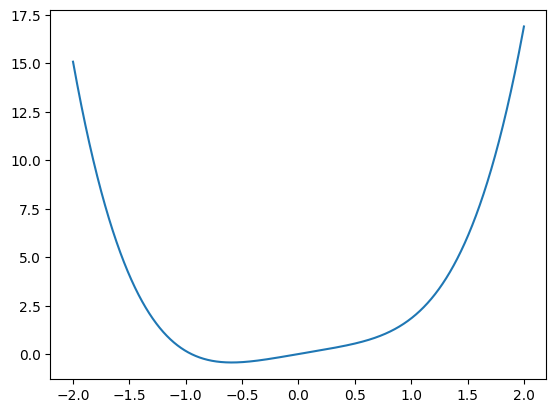

In [11]:
# Постройте график функции y на отрезке [-2; 2]

x = np.linspace(-2, 2, num=10000)
y = func_y(x)

plt.plot(x, y)
plt.show()

In [12]:
# Задайте параметры для нахождения минимума

x0 = 1
learning_rate = 0.1
n_iter = 1000

In [13]:
# Для удобства рекомендуется реализовать градиентный спуск с помощью функции (не обязательно)

def gradient_descent(x0, learning_rate, n_iter):
  last_iter = n_iter
  for i in range(n_iter):
    grad = gradient_y(x0)
    if abs(grad) < 1e-2:
      last_iter = i + 1
      break
    x0 -= learning_rate * grad
  print(last_iter)
  return x0

In [14]:
# Найдите минимум функции y

x_min = gradient_descent(x0, learning_rate, n_iter)
y_min = func_y(x_min)

19


In [15]:
x_min, y_min

(np.float64(-0.5899957115789375), np.float64(-0.4351873724522652))

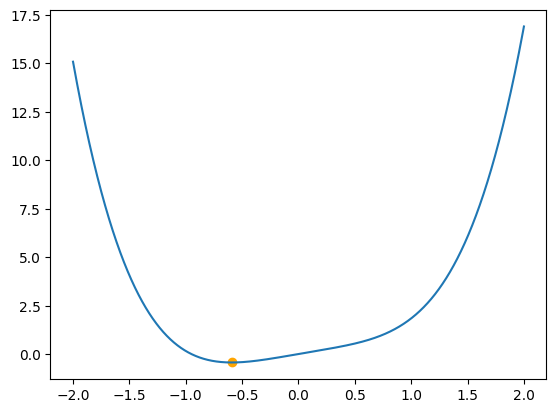

In [16]:
# Постройте график функции y на отрезке [-2; 2]
# Дополните график точкой минимума

plt.plot(x, y)
plt.scatter(x=x_min, y=y_min, color='orange')
plt.show()

Рассчитайте и выберите из списка значение оптимального темпа обучения.

Результат округлён до 4-х знаков после запятой.
0.1000
4.5431
0.1519
0.2541
0.3506
0.2537
0.2833
1.5916


In [17]:
# Рассчитайте оптимальный темп обучения
# Начальное приближение (x0): 1

lrs = [0.1000, 4.5431, 0.1519, 0.2541, 0.3506, 0.2537, 0.2833, 1.5916]

for lr in lrs:
  gradient_descent(x0, lr, n_iter)

19
1000
12
6
2
6
6
1000


In [18]:
# Проверьте четыре значения темпа обучения на сходимость реализованного алгоритма
# Начальное приближение (x0): 1
# Количество итераций (n_iter): 1000.

learning_rates = [0.4, 0.5, 0.6, 0.7]

for lr in learning_rates:
  print(gradient_descent(x0, lr, n_iter))

4
-0.5936034325752475
1000
nan
1000
nan
1000
nan


### **Датасет *Diabetes prediction dataset***

**Для решения заданий 2 — 9 рассмотрим датасет [Diabetes prediction dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data).**

**ВНИМАНИЕ:** При решении заданий **используйте файл diabetes.csv** из приложения к ноутбуку, поскольку исходный датасет был изменен авторами курса.

Набор данных предназначен для обучения и тестирования моделей бинарной классификации. Его основная цель — предсказать, есть ли у пациента диабет 2-го типа или нет. Набор данных включает в себя медицинские и демографические данные пациентов, а также информацию об их диабетическом статусе (положительный или отрицательный).

Целевая переменная — diabetes (диабетический статус):

* 1 — диагностирован диабет (**целевой класс**).

* 0 — диабет не диагностирован.

Датасет содержит признаки:

* gender — пол.

* age — возраст (в годах).

* hypertension — наличие гипертонии.

* heart_disease — наличие сердечно-сосудистых заболеваний.

* bmi — индекс массы тела (BMI).

* HbA1c_level — уровень гликированного гемоглобина.

* blood_glucose_level — уровень глюкозы в крови.

### **Калибровочная кривая и ECE**

**Калибровочная кривая (Calibration Curve)** — это инструмент для визуальной оценки того, насколько хорошо откалибрована модель. Она показывает соотношение между предсказанными вероятностями модели и фактической долей положительных исходов (реальным частотам положительных классов). На графике по оси X откладывается средняя предсказанная вероятность, а по оси Y — фактическая доля положительных классов.

**ECE (Expected Calibration Error)** — это метрика, которая позволяет численно измерить ошибку калибровки.

$$ECE=\sum_{m=1}^{M}{\frac{|B_m|}{n}{|acc(B_m) - conf(B_m)|}}$$

где $M$ — количество бинов, $|B_m|$ — число предсказаний в бине $B_m$, $n$ — общее количество наблюдений, $acc(B_m)$ — доля истинных положительных результатов (эмпирическая вероятность) в бине $B_m$, $conf(B_m)$ — средняя предсказанная вероятность в бине $B_m$.

При построении калибровочных кривых и расчёте ECE, все предсказания модели (например, из тестовой выборки) делятся на бины (группы) по уровню предсказанной вероятности. Как правило, используется метод равномерного (uniform) распределения бинов (интервалы бинов имеют равную длину). Например, в первый бин попадают все объекты с предсказанной вероятностью от 0 до 0.1, во второй — от 0.1 до 0.2, и так далее.

Подробнее можно изучить по **ссылкам:**

* [Калибровочные кривые | scikit-learn.ru](https://scikit-learn.ru/stable/modules/calibration.html#calibration-curve)

* [Expected Calibration Error (ECE): A Step-by-Step Visual Explanation | towardsdatascience.com](https://towardsdatascience.com/expected-calibration-error-ece-a-step-by-step-visual-explanation-with-python-code-c3e9aa12937d/)


### **Когда использовать AUC, а когда — ECE**

**AUC (Area Under the ROC Curve)** — это метрика качества ранжирования. Она показывает, насколько хорошо модель способна отличать один класс от другого, присваивая объектам положительного класса более высокие оценки, чем объектам отрицательного. Высокий AUC означает, что модель хорошо разделяет классы.

**Использовать AUC следует, когда в решаемой задаче важен порядок объектов, а не точные значения вероятностей.**

**ECE (Expected Calibration Error)** — это метрика качества вероятностей. Она оценивает, соответствуют ли предсказанные моделью вероятности реальным частотам событий. Низкий ECE означает, что модель надежна, и её вероятностям можно доверять.

**Использовать ECE следует, когда в решаемой задаче важны точные вероятности, а цена ошибки высока.**

### ***Задание 2***

Выполните предобработку датасета (см. код задания) и обучите три модели логистической регрессии (LogisticRegression) на обучающей выборке:

* `lr_diab` — логистическая регрессия **без регуляризации** на данных **без масштабирования** (`X_diab_train`).

* `lr_diab_def` — логистическая регрессия **с регуляризацией по умолчанию** на данных **с масштабированием** (`X_diab_train_scaled`).

* `lr_diab_opt` — логистическая регрессия **с оптимальным гиперпараметром регуляризации** на данных **с масштабированием** (`X_diab_train_scaled`). Оптимальный гиперпараметр регуляризации подберите с помощью GridSearchCV.

Сравните качество калибровки моделей **на тестовой выборке**. Для этого постройте калибровочные кривые (функция [calibration_curve](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html)) и посчитайте метрику ECE (функция ece_score) для каждой из обученных моделей. На основе значения ECE выберите модель с наилучшей калибровкой.

Сравните значение метрики AUC **на тестовой выборке** для обученных моделей.

**ВНИМАНИЕ:** При предобработке датасета разделите датасет на обучающую (60%) и тестовую (40%) выборки **со стратификацией по целевой переменной** (параметр stratify в [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).

In [19]:
# Считайте набор данных

df_diab = pd.read_csv('/content/drive/MyDrive/diabetes.csv')
df_diab

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,57.0,No,No,18.87,4.8,140,0
1,Female,39.0,No,No,27.32,6.1,130,0
2,Female,15.0,No,No,38.72,5.7,159,0
3,Female,60.0,No,No,25.10,5.7,140,0
4,Male,12.0,No,No,17.26,4.5,126,0
...,...,...,...,...,...,...,...,...
99977,Female,38.0,No,No,32.84,4.0,155,0
99978,Male,17.0,No,No,25.26,5.0,155,0
99979,Male,2.0,No,No,27.32,5.0,90,0
99980,Female,80.0,No,No,20.54,6.6,140,0


In [20]:
# Используя метод info, определите типы признаков

df_diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99982 entries, 0 to 99981
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               99982 non-null  object 
 1   age                  99982 non-null  float64
 2   hypertension         99982 non-null  object 
 3   heart_disease        99982 non-null  object 
 4   bmi                  99982 non-null  float64
 5   HbA1c_level          99982 non-null  float64
 6   blood_glucose_level  99982 non-null  int64  
 7   diabetes             99982 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 6.1+ MB


In [21]:
# Создайте списки количественных и категориальных переменных (не включая целевую переменную)

diab_num_feat = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
diab_cat_feat = ['gender', 'hypertension', 'heart_disease']

In [22]:
# Выделите объясняемый фактор в отдельную переменную

X_diab, y_diab = df_diab.drop('diabetes', axis=1), df_diab['diabetes']

In [23]:
# Закодируйте категориальные признаки числами 0 и 1 с помощью OneHotEncoder

diab_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')

X_diab_encoded = diab_encoder.fit_transform(X_diab[diab_cat_feat])
X_diab = X_diab.join(X_diab_encoded)
X_diab = X_diab.drop(columns=diab_cat_feat)

In [24]:
# Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной
# Не забудьте зафиксировать RANDOM_STATE

X_diab_train, X_diab_test, y_diab_train, y_diab_test = train_test_split(X_diab, y_diab, train_size=0.6, test_size=0.4, stratify=y_diab, random_state=RANDOM_STATE)

In [25]:
# Масштабируйте количественные признаки
#   train -> fit_transform
#   test -> transform

diab_scaler = StandardScaler().set_output(transform='pandas')

X_diab_train_scaled = diab_scaler.fit_transform(X_diab_train)
X_diab_test_scaled = diab_scaler.transform(X_diab_test)

In [26]:
# Обучите модель lr_diab без регуляризации на данных без масштабирования
# Не забудьте зафиксировать RANDOM_STATE

lr_diab = LogisticRegression(penalty=None, random_state=RANDOM_STATE).fit(X_diab_train, y_diab_train)

In [27]:
# Обучите модель lr_diab_def с регуляризацией по умолчанию на данных с масштабированием
# Не забудьте зафиксировать RANDOM_STATE

lr_diab_def = LogisticRegression(random_state=RANDOM_STATE).fit(X_diab_train_scaled, y_diab_train)

In [28]:
# Обучите модель lr_diab_opt с оптимальным гиперпараметром регуляризации на данных с масштабированием
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {'C' : [0.1, 0.3, 0.5, 0.7, 1.0]}
cv = 5

cv_lr_diab_opt = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE),
    param_grid=params,
    scoring='roc_auc',
    cv=cv
)
cv_lr_diab_opt.fit(X_diab_train_scaled, y_diab_train)
lr_diab_opt = LogisticRegression(**cv_lr_diab_opt.best_params_, random_state=RANDOM_STATE).fit(X_diab_train_scaled, y_diab_train)

In [29]:
# Выведите оптимальное значение гиперпараметра C

C_opt = cv_lr_diab_opt.best_params_
C_opt

{'C': 0.1}

In [30]:
# Выполните предсказание вероятностей целевого класса на тестовой выборке моделью lr_diab
# Учтите, что lr_diab обучалась на данных без масштабирования

y_test_proba_lr_diab = lr_diab.predict_proba(X_diab_test)[:, 1]
y_test_proba_lr_diab

array([0.0041953 , 0.02524553, 0.02605382, ..., 0.00039779, 0.13479217,
       0.00171608])

In [31]:
# Выполните предсказание вероятностей целевого класса на тестовой выборке моделью lr_diab_def
# Учтите, что lr_diab_def обучалась на данных с масштабированием

y_test_proba_lr_diab_def = lr_diab_def.predict_proba(X_diab_test_scaled)[:, 1]

In [32]:
# Выполните предсказание вероятностей целевого класса на тестовой выборке моделью lr_diab_opt
# Учтите, что lr_diab_opt обучалась на данных с масштабированием

y_test_proba_lr_diab_opt = lr_diab_opt.predict_proba(X_diab_test_scaled)[:, 1]

In [33]:
# Просчитайте калибровочные кривые моделей на тестовой выборке, используя calibration_curve (n_bins=10)

prob_true_lr_diab, prob_pred_lr_diab = calibration_curve(y_diab_test, y_test_proba_lr_diab, n_bins=10)
prob_true_lr_diab_def, prob_pred_lr_diab_def = calibration_curve(y_diab_test, y_test_proba_lr_diab_def, n_bins=10)
prob_true_lr_diab_opt, prob_pred_lr_diab_opt = calibration_curve(y_diab_test, y_test_proba_lr_diab_opt, n_bins=10)

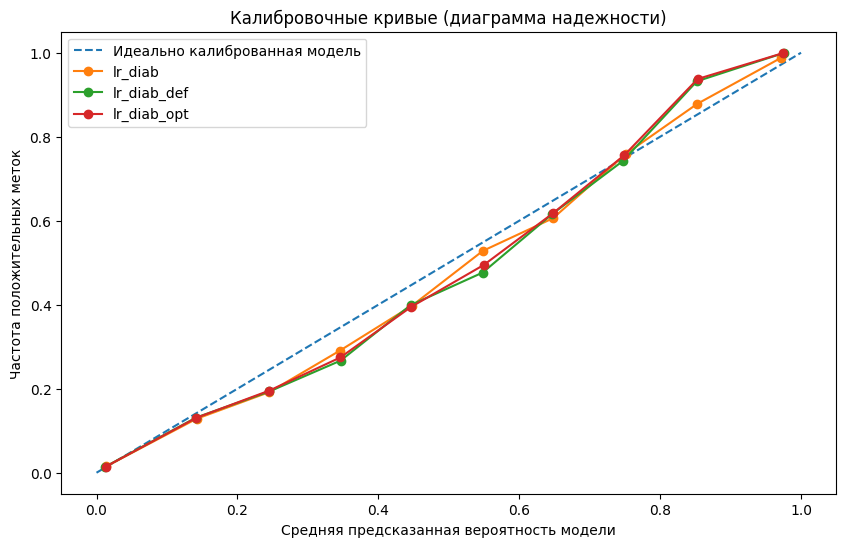

In [34]:
# Визуализируйте калибровочные кривые

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='Идеально калиброванная модель')
plt.plot(prob_pred_lr_diab, prob_true_lr_diab, marker='o', label='lr_diab')
plt.plot(prob_pred_lr_diab_def, prob_true_lr_diab_def, marker='o', label='lr_diab_def')
plt.plot(prob_pred_lr_diab_opt, prob_true_lr_diab_opt, marker='o', label='lr_diab_opt')
plt.xlabel('Средняя предсказанная вероятность модели')
plt.ylabel('Частота положительных меток')
plt.title('Калибровочные кривые (диаграмма надежности)')
plt.legend()
plt.show()

In [35]:
# Посчитайте метрику ECE для каждой из моделей, используя функцию ece_score

ece_score(y_diab_test, y_test_proba_lr_diab), ece_score(y_diab_test, y_test_proba_lr_diab_def), ece_score(y_diab_test, y_test_proba_lr_diab_opt)

(np.float64(0.005499704809704019),
 np.float64(0.007160101258833732),
 np.float64(0.006749964516285242))

In [36]:
# Посчитайте метрику AUC для каждой из моделей, используя функцию roc_auc_score

roc_auc_score(y_diab_test, y_test_proba_lr_diab), roc_auc_score(y_diab_test, y_test_proba_lr_diab_def), roc_auc_score(y_diab_test, y_test_proba_lr_diab_opt)

(np.float64(0.9594172422883837),
 np.float64(0.9618389365693536),
 np.float64(0.9618983580916313))

### ***Задание 3***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Датасет **до масштабирования** из задания 2: `X_diab`, `y_diab`.

* Оптимальное значение гиперпараметра регуляризации C из задания 2: `C_opt`.

Проверьте, является ли разница в калибровочной точности моделей `lr_diab`, `lr_diab_def`, `lr_diab_opt` значимой (равны ли метрики ECE для данных моделей в среднем). Для проверки равенства средних значений в трех группах (векторы значений ECE для каждой из трех моделей) используйте t-тесты и F-тест для регрессии statsmodels (OLS) с фиктивными переменными для групп.

**Посчитайте векторы значений ECE для 100 различных random_state.** Для каждой итерации $i=0,...,99$ (100 итераций):

**ВНИМАНИЕ:** Где возможно, фиксируйте random_state для итерации $i$ на значении $i$.

1. Разделите `X_diab` на обучающую (60%, `X_diab_i_train`) и валидационную (40%, `X_diab_i_val`) **подвыборки со стратификацией** по целевой переменной. Не забудьте зафиксировать random_state=$i$.

2. Обучите три модели логистической регрессии на обучающей подвыборке `X_diab_i_train` (не забудьте масштабировать подвыборки `X_diab_i_train` и `X_diab_i_val` для моделей с регуляризацией, зафиксировать random_state=$i$):
    
    * `lr_diab_i` — логистическая регрессия **без регуляризации** на данных **без масштабирования** (`X_diab_i_train`).

    * `lr_diab_i_def` — логистическая регрессия **с регуляризацией по умолчанию** на данных **с масштабированием** (`X_diab_i_train_scaled`).

    * `lr_diab_i_opt` — логистическая регрессия **с оптимальным гиперпараметром регуляризации** `C_opt` на данных **с масштабированием** (`X_diab_i_train_scaled`). Используйте оптимальный гиперпараметр регуляризации `C_opt` из задания 2.

3. Посчитайте метрику ECE (функция ece_score) для каждой из обученных моделей.

Используя линейную регрессию statsmodels (OLS) и векторы значений ECE, **проверьте гипотезу о равенстве средних значений метрики ECE** в трех группах:

1. Обучите модель линейной регрессии statsmodels (OLS) `ols_ece_diab` с факторными группами (с фиктивными переменными):

    $$y = \alpha+\beta_{default}D_{default}+\beta_{optimal}D_{optimal}​+ϵ$$

    где $\alpha=\text{ECE}^{no\_penalty}_{mean}$ — среднее значение ECE в группе с меткой $M^{no\_penalty}$ (среднее ECE для модели `lr_diab`), $D_{m}$ — индикатор модели с меткой $M^{m}$.

2. Интерпретируя summary модели `ols_ece_diab`, проверьте гипотезу о равенстве средних в трех группах с помощью t-теста для коэффициентов $\beta_{default}$ и $\beta_{optimal}$, а также F-теста для всей модели.

In [37]:
# Посчитайте векторы значений ECE для 100 различных random_state
# Для записи результатов итераций создадим датафрейм diab_ece_scores, заполненный нулями

diab_ece_scores = pd.DataFrame({
    'ece_no_penalty': np.zeros(100),
    'ece_default': np.zeros(100),
    'ece_optimal': np.zeros(100)
}, index=range(100)
)

for i in range(100):
    X_diab_i_train, X_diab_i_val, y_diab_i_train, y_diab_i_val = train_test_split(X_diab, y_diab, train_size=0.6, test_size=0.4, random_state=i, stratify=y_diab)

    scaler = StandardScaler().set_output(transform='pandas')
    X_diab_i_train_scaled = scaler.fit_transform(X_diab_i_train)

    lr_diab_i = LogisticRegression(penalty=None, random_state=i).fit(X_diab_i_train, y_diab_i_train)
    lr_diab_i_def = LogisticRegression(random_state=i).fit(X_diab_i_train_scaled, y_diab_i_train)
    lr_diab_i_opt = LogisticRegression(C=C_opt['C'], random_state=i).fit(X_diab_i_train_scaled, y_diab_i_train)

    X_diab_i_val_scaled = scaler.transform(X_diab_i_val)

    y_test_proba_lr_diab_i = lr_diab_i.predict_proba(X_diab_i_val)[:, 1]
    y_test_proba_lr_diab_def_i = lr_diab_i_def.predict_proba(X_diab_i_val_scaled)[:, 1]
    y_test_proba_lr_diab_opt_i = lr_diab_i_opt.predict_proba(X_diab_i_val_scaled)[:, 1]

    diab_ece_scores.iloc[i] = np.array([
        ece_score(y_diab_i_val, y_test_proba_lr_diab_i),
        ece_score(y_diab_i_val, y_test_proba_lr_diab_def_i),
        ece_score(y_diab_i_val, y_test_proba_lr_diab_opt_i)
    ])

In [38]:
# Выведите средние значения ECE в каждой из трех групп

diab_ece_scores.mean()

,0
ece_no_penalty,0.006238
ece_default,0.006751
ece_optimal,0.006418


In [39]:
# Представим значения ECE в виде двух векторов: метка группы (group) и ECE наблюдения, соответствующего метке (ECE)

diab_ece_groups = diab_ece_scores.melt()
diab_ece_groups.columns = ['group', 'ECE']
diab_ece_groups

,group,ECE
0,ece_no_penalty,0.004082
1,ece_no_penalty,0.005382
2,ece_no_penalty,0.005823
3,ece_no_penalty,0.007371
4,ece_no_penalty,0.003273
...,...,...
295,ece_optimal,0.006649
296,ece_optimal,0.005964
297,ece_optimal,0.007287
298,ece_optimal,0.007069


In [40]:
# Сформируйте датафрейм для проверки гипотезы
# Добавьте в датафрейм два столбца с фиктивными переменными:
#   D_default = 1, если group = 'ece_default'; 0 — иначе
#   D_optimal = 1, если group = 'ece_optimal'; 0 — иначе

diab_ece_groups['D_default'] = (diab_ece_groups['group'] == 'ece_default').astype(int)
diab_ece_groups['D_optimal'] = (diab_ece_groups['group'] == 'ece_optimal').astype(int)
diab_ece_groups = diab_ece_groups.drop(columns=['group'])
diab_ece_groups

,ECE,D_default,D_optimal
0,0.004082,0,0
1,0.005382,0,0
2,0.005823,0,0
3,0.007371,0,0
4,0.003273,0,0
...,...,...,...
295,0.006649,0,1
296,0.005964,0,1
297,0.007287,0,1
298,0.007069,0,1


In [41]:
# Выделите столбец ECE датафрейма diab_ece_groups в отдельную переменную

X_diab_ece_groups, y_diab_ece_groups = diab_ece_groups.drop('ECE', axis=1), diab_ece_groups['ECE']

In [42]:
# Проверьте гипотезу о равенстве средних значений метрики ECE в трех группах, используя ols_ece_diab
# Выведите summary для ols_ece_diab
# Перед обучением ols_ece_diab необходимо добавить константу к X_diab_ece_groups с помощью метода add_constant

X_diab_ece_groups_const = sm.add_constant(X_diab_ece_groups)
ols_ece_diab = OLS(y_diab_ece_groups, X_diab_ece_groups).fit()
print(ols_ece_diab.summary())

                                 OLS Regression Results                                
Dep. Variable:                    ECE   R-squared (uncentered):                   0.675
Model:                            OLS   Adj. R-squared (uncentered):              0.673
Method:                 Least Squares   F-statistic:                              309.1
Date:                Fri, 20 Feb 2026   Prob (F-statistic):                    2.07e-73
Time:                        00:22:25   Log-Likelihood:                          1251.4
No. Observations:                 300   AIC:                                     -2499.
Df Residuals:                     298   BIC:                                     -2491.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### ***Задание 4***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Тестовую выборку **до масштабирования** из задания 2: `X_diab_test`, `y_diab_test`.

* Обученную модель `lr_diab` из задания 3.

В рамках тестовой выборки `X_diab_test` отберите несколько пациентов по заданным условиям (метод [query](https://pandas.pydata.org/docs/user_guide/indexing.html#the-query-method)) и с помощью модели `lr_diab` предскажите вероятности целевого класса для каждого из этих пациентов. Условия для отбора пациентов:

* Возраст — 54.

* Пол — мужчина.

* Наличие гипертонии — нет.

* Наличие сердечно-сосудистых заболеваний — да.

* Индекс массы тела (BMI) — от 27 (включительно) до 28 (включительно).

* Уровень гликированного гемоглобина — не меньше 6.

* Уровень глюкозы в крови — не больше 155.

In [43]:
X_diab_test.sample(3)

,age,bmi,HbA1c_level,blood_glucose_level,gender_Male,hypertension_Yes,heart_disease_Yes
10335,69.00,25.28,5.0,100,0.0,0.0,0.0
90150,0.56,19.61,3.5,145,1.0,0.0,0.0
11132,80.00,27.32,3.5,155,0.0,0.0,0.0


In [44]:
# В рамках тестовой выборки X_diab_test отберите несколько пациентов по заданным условиям

X_diab_test_sample = X_diab_test.query('age == 54 and gender_Male == 1.0 and hypertension_Yes == 0.0 and heart_disease_Yes == 1.0 and bmi > 27.0 and bmi < 28.0 and HbA1c_level >= 6.0 and blood_glucose_level <= 155.0')
diab_test_sample_ids = X_diab_test_sample.index
X_diab_test_sample

,age,bmi,HbA1c_level,blood_glucose_level,gender_Male,hypertension_Yes,heart_disease_Yes
3327,54.0,27.32,8.8,130,1.0,0.0,1.0
94355,54.0,27.32,6.0,85,1.0,0.0,1.0
72982,54.0,27.32,6.5,155,1.0,0.0,1.0


In [45]:
y_diab.iloc[diab_test_sample_ids]

,diabetes
3327,1
94355,0
72982,0


In [46]:
# C помощью модели lr_diab предскажите вероятности целевого класса для каждого из пациентов в X_diab_test_sample

y_test_sample_lr_diab = pd.Series(lr_diab.predict_proba(X_diab_test_sample)[:, 1], index=diab_test_sample_ids)
y_test_sample_lr_diab

,0
3327,0.984612
94355,0.032684
72982,0.487272


### ***Задание 5***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Тестовую выборку **до масштабирования** из задания 2: `X_diab_test`, `y_diab_test`.

* Датасет с отобранными в задании 4 пациентами: `X_diab_test_sample`.

* Обученную модель `lr_diab` из задания 3.

Для отобранных пациентов (`X_diab_test_sample`) скорректируйте данные при следующих **последовательных** событиях:

1. Событие 1: коррекция оборудования. Выяснилось, что оборудование, собирающее анализы у пациентов, завышает значение уровня гликированного гемоглобина (HbA1c_level) у всех отобранных пациентов на 0.2. Уменьшите значение гликированного гемоглобина (HbA1c_level) у отобранных пациентов на 0.2.

2. Событие 2: уточнение диагноза. Благодаря новым методам диагностики, у некоторых пациентов была диагностирована гипертония, в том числе и у всех отобранных пациентов. Для отобранных пациентов установите флаг наличия гипертонии (hypertension = 1).

3. Событие 3: учет погрешности измерений. Чтобы учесть возможность ошибки в результатах анализов, было принято решение также считать вероятность диабета в случае, когда уровень глюкозы в крови (blood_glucose_level) выше текущего на величину стандартного отклонения в выборке (тестовой). Для отобранных пациентов увеличьте уровень глюкозы в крови (blood_glucose_level) на величину стандартного отклонения blood_glucose_level в тестовой выборке `X_diab_test_sample`.

После каждой коррекции данных определите изменение вероятности предсказания наличия диабета для отобранных пациентов.

In [47]:
X_diab_test_sample

,age,bmi,HbA1c_level,blood_glucose_level,gender_Male,hypertension_Yes,heart_disease_Yes
3327,54.0,27.32,8.8,130,1.0,0.0,1.0
94355,54.0,27.32,6.0,85,1.0,0.0,1.0
72982,54.0,27.32,6.5,155,1.0,0.0,1.0


In [48]:
# Событие 1: коррекция оборудования
# Определите изменение вероятности предсказания наличия диабета при изменении HbA1c_level

X_diab_test_sample_copy = X_diab_test_sample.copy()

prob_before_1 = lr_diab.predict_proba(X_diab_test_sample_copy)[:, 1].copy()
X_diab_test_sample_copy['HbA1c_level'] -= 0.2
prob_after_1 = lr_diab.predict_proba(X_diab_test_sample_copy)[:, 1]

delta_prob_1 = prob_after_1 - prob_before_1
y_test_sample_lr_diab_1 = pd.Series(lr_diab.predict_proba(X_diab_test_sample_copy)[:, 1], index=diab_test_sample_ids)
y_test_sample_lr_diab_1

,0
3327,0.976405
94355,0.021385
72982,0.380657


In [49]:
# Событие 2: уточнение диагноза
# Определите изменение вероятности предсказания наличия диабета при изменении hypertension
# ВНИМАНИЕ: корректировка hypertension происходит после изменения HbA1c_level

prob_before_2 = lr_diab.predict_proba(X_diab_test_sample_copy)[:, 1].copy()
X_diab_test_sample_copy['hypertension_Yes'] = 1.0
prob_after_2 = lr_diab.predict_proba(X_diab_test_sample_copy)[:, 1]

delta_prob_2 = prob_after_2 - prob_before_2
y_test_sample_lr_diab_2 = pd.Series(lr_diab.predict_proba(X_diab_test_sample_copy)[:, 1], index=diab_test_sample_ids)
y_test_sample_lr_diab_2


,0
3327,0.980636
94355,0.026045
72982,0.429272


In [50]:
# Событие 3: учет погрешности измерений
# Определите изменение вероятности предсказания наличия диабета при изменении blood_glucose_level
# ВНИМАНИЕ: корректировка blood_glucose_level происходит после изменения HbA1c_level и hypertension

prob_before_3 = lr_diab.predict_proba(X_diab_test_sample_copy)[:, 1].copy()
X_diab_test_sample_copy['blood_glucose_level'] += X_diab_test['blood_glucose_level'].std()
prob_after_3 = lr_diab.predict_proba(X_diab_test_sample_copy)[:, 1]

delta_prob_3 = prob_after_3 - prob_before_3
y_test_sample_lr_diab_3 = pd.Series(lr_diab.predict_proba(X_diab_test_sample_copy)[:, 1], index=diab_test_sample_ids)
y_test_sample_lr_diab_3

,0
3327,0.994700
94355,0.090178
72982,0.735991


In [51]:
delta_prob_1, delta_prob_2, delta_prob_3

(array([-0.00820747, -0.01129968, -0.10661481]),
 array([0.00423103, 0.0046607 , 0.0486154 ]),
 array([0.01406491, 0.06413223, 0.30671925]))

### **ColumnTransformer и Pipeline**

ColumnTransformer и Pipeline из библиотеки scikit-learn — это инструменты, которые позволяют автоматизировать и упорядочить процесс предобработки данных для обучения моделей машинного обучения.

**ColumnTransformer** — это инструмент, позволяющий применять различные преобразования к разным столбцам данных (например, числовым и категориальным), объединяя результаты в единую табличную структуру. Это особенно полезно для датасетов с разнородными типами признаков.

В рамках заданий ColumnTransformer будет использоваться для автоматизации стандартных шагов предобработки (масштабирование числовых признаков и One-Hot кодирование категориальных признаков) перед подачей их в модель.

**Pipeline (пайплайн, конвейер)** — это инструмент объединения последовательности этапов обработки данных и обучения модели в единый объект. Каждый этап пайплайна должен быть трансформатором (иметь методы fit и transform), кроме последнего, который может быть моделью (например, классификатором или регрессором). Это инкапсулирует всю цепочку действий, предотвращает утечку данных на обучающих/тестовых выборках, облегчает повторяемость экспериментов, делает код прозрачным и легко расширяемым.

Pipeline интегрируется с инструментами автоматического подбора гиперпараметров (например, GridSearchCV или RandomizedSearchCV), с помощью чего возможно оптимизировать параметры как препроцессора, так и самой модели.

В рамках заданий будет рассматриваться простейший пример пайплайна, где первым шагом выступает ColumnTransformer, а вторым — модель (например, LogisticRegression).

*Поскольку пайплайн объединяет этапы обработки данных и сам алгоритм обучения в единый объект с методами fit и predict, его **упрощенно можно назвать моделью**. При этом важно помнить, что внутри пайплайна модель — это последний шаг, а предыдущие шаги отвечают за преобразование признаков.*

* [Column Transformer with Mixed Types | scikit-learn.org](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

* [Pipelines and composite estimators | scikit-learn.org](https://scikit-learn.org/stable/modules/compose.html)

### ***Задание 6***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Исходный датасет Diabetes prediction dataset из задания 2: `df_diab`.

Выполните предобработку датасета `df_diab` и постройте пайплайн `pipe_clf`:

1. Выделите объясняемый фактор в отдельную переменную `y_pipe`.

2. Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной.

3. Определите правило предобработки колонок с помощью `pipe_col_prep` (ColumnTransformer):

    * Для категориальных переменных `diab_cat_feat` ('cat') — OneHotEncoder(drop='first', sparse_output=False).

    * Для количественных переменных `diab_num_feat` ('num') — StandardScaler().

4. Постройте пайплайн `pipe_clf` (Pipeline) из двух шагов:

    1. 'col_prep': `pipe_col_prep`.

    2. 'clf': LogisticRegression.

Используя пайплайн `pipe_clf`, подберите оптимальный гиперпараметр регуляризации с помощью GridSearchCV **(метрика оптимизации — AUC)** и обучите модель с оптимальным параметром регуляризации `lr_pipe`.

Используя регрессионные коэффициенты обученной модели `lr_pipe`, определите признак, который оказывает наибольшее влияние на прогноз диагноза (*подсказка: для извлечения коэффициентов используйте аттрибут named_steps*). Сравните коэффициенты модели `lr_pipe` (`pipe_coefs`) с коэффициентами модели `lr_diab` (`diab_coefs`).

In [52]:
# Выделите объясняемый фактор в отдельную переменную

X_pipe, y_pipe = df_diab.drop(columns=['diabetes']), df_diab['diabetes']

In [53]:
# Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной
# Не забудьте зафиксировать RANDOM_STATE

X_pipe_train, X_pipe_test, y_pipe_train, y_pipe_test = train_test_split(X_pipe, y_pipe, train_size=0.6, test_size=0.4, stratify=y_pipe, random_state=RANDOM_STATE)

In [54]:
# Определите правило предобработки колонок с помощью pipe_col_prep (ColumnTransformer)

pipe_col_prep = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas'), diab_cat_feat),
        ('num', StandardScaler().set_output(transform='pandas'), diab_num_feat),
    ]
)

In [55]:
# Постройте пайплайн pipe_clf
# Не забудьте зафиксировать RANDOM_STATE

pipe_clf = Pipeline(
    steps=[
        ('col_prep', pipe_col_prep),
        ('clf', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [56]:
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV

params = {'clf__C' : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
cv = 5
scoring = 'roc_auc'

cv_lr_pipe = GridSearchCV(
    estimator=pipe_clf,
    param_grid=params,
    cv=cv,
    scoring=scoring
).fit(X_pipe_train, y_pipe_train)

In [57]:
# Выведите оптимальное значение гиперпараметра C

cv_lr_pipe.best_params_

{'clf__C': 0.05}

In [58]:
# Обучите модель lr_pipe с оптимальным гиперпараметром регуляризации

pipe_clf.set_params(**cv_lr_pipe.best_params_)
lr_pipe = pipe_clf.fit(X_pipe_train, y_pipe_train)

In [59]:
# Используя коэффициенты lr_pipe, определите признак, который оказывает наибольшее влияние на прогноз диагноза

# Получаем имена колонок после трансформации
ohe_cols = lr_pipe.named_steps['col_prep'].named_transformers_['cat'].get_feature_names_out(diab_cat_feat)
num_cols = diab_num_feat
all_cols = np.concatenate([ohe_cols, num_cols])

# Коэффициенты модели
coefs = lr_pipe.named_steps['clf'].coef_[0]

pipe_coefs = pd.DataFrame({
    'feature': all_cols,
    'coef': coefs
}).sort_values(by='coef', key=abs, ascending=False)

# pipe_coefs = pd.DataFrame({
#     'lr_pipe coef': lr_pipe.coef_
# }, index=lr_pipe.columns)

pipe_coefs

,feature,coef
5,HbA1c_level,2.403829
6,blood_glucose_level,1.307091
3,age,1.038600
1,hypertension_Yes,0.719970
2,heart_disease_Yes,0.655183
4,bmi,0.573836
0,gender_Male,0.273350


In [60]:
most_influential_feature = pipe_coefs.iloc[0]['feature']

In [61]:
# Сравните коэффициенты lr_pipe (pipe_coefs) с коэффициентами lr_diab (diab_coefs)

diab_coefs = pd.DataFrame({
    'feature': X_diab_train.columns,
    'coef': lr_diab.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)

diab_coefs

,feature,coef
2,HbA1c_level,2.179184
6,heart_disease_Yes,2.009798
4,gender_Male,-0.239284
5,hypertension_Yes,0.201940
1,bmi,0.081730
0,age,0.040979
3,blood_glucose_level,0.032102


### ***Задание 7***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обученную модель `lr_pipe` из задания 6.

* Тестовую выборку из задания 6: `X_pipe_test`, `y_pipe_test`.

На тестовой выборке постройте матрицу ошибок для прогноза целевого класса моделью `lr_pipe` (функция [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)).

На тестовой выборке интерпретируйте матрицу ошибок для модели `lr_pipe`, выбрав все верные утверждения из списка (см. тест):

* Модель `lr_pipe` спрогнозировала у пациента из тестовой выборки наличие диабета. Вероятность ошибки этого прогноза больше 10%.

* Врачи диагностировали у пациента из тестовой выборки диабет. Модель `lr_pipe` сможет сделать правильный прогноз для данного пациента с вероятностью, большей 80%.

* Модель `lr_pipe` предоставила неверный прогноз для пациентов (в тестовой выборке), которые в реальности не имеют диагностированный диабет, больше, чем в 2% случаев.

* Те пациенты (в тестовой выборке), у кого было предсказано отсутствие диабета (с помощью `lr_pipe`), в действительности имеют диабет менее, чем в 4% случаев.

Постройте отчет по метрикам классификации (функция [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)) для модели `lr_pipe` на тестовой выборке и интерпретируйте результаты отчета.

In [62]:
# Выполните прогноз целевого класса на тестовой выборке с помощью модели lr_pipe

y_test_pred_lr_pipe = lr_pipe.predict(X_pipe_test)

In [63]:
# Постройте матрицу ошибок для прогноза

pipe_confusion_matrix = confusion_matrix(y_pipe_test, y_test_pred_lr_pipe)

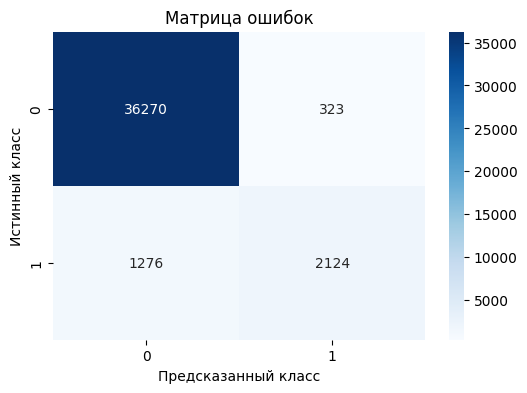

In [64]:
# Визуализируйте матрицу ошибок для удобства в интерпретации

plt.figure(figsize=(6, 4))
ax = sns.heatmap(pipe_confusion_matrix, annot=True, cmap='Blues', fmt='g')
ax.set_title('Матрица ошибок')
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
plt.show()

# 36270 323
# 1276 2124

In [65]:
# Модель lr_pipe спрогнозировала у пациента из тестовой выборки наличие диабета. Вероятность ошибки этого прогноза больше 10%

2124 / (2124 + 323) # Да

0.8680016346546792

In [66]:
# Врачи диагностировали у пациента из тестовой выборки диабет. Модель lr_pipe сможет сделать правильный прогноз для данного пациента с вероятностью, большей 80%

2124 / (2124 + 1276) # Нет

0.6247058823529412

In [67]:
# Модель lr_pipe предоставила неверный прогноз для пациентов (в тестовой выборке), которые в реальности не имеют диагностированный диабет, больше, чем в 2% случаев

323 / (323 + 36270) # Нет

0.008826824802557866

In [68]:
# Те пациенты (в тестовой выборке), у кого было предсказано отсутствие диабета (с помощью lr_pipe), в действительности имеют диабет менее, чем в 4% случаев.

1276 / (1276 + 36270) # Да

0.03398497842646354

In [69]:
# Постройте отчет по метрикам классификации

roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

(<function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>,
 <function sklearn.metrics._ranking.roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)>,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, samp

In [70]:
print(classification_report(y_pipe_test, y_test_pred_lr_pipe))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     36593
           1       0.87      0.62      0.73      3400

    accuracy                           0.96     39993
   macro avg       0.92      0.81      0.85     39993
weighted avg       0.96      0.96      0.96     39993



### **Задание 8**

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обученную модель `lr_pipe` из задания 6.

* Тестовую выборку из задания 6: `X_pipe_test`, `y_pipe_test`.

Постройте ROC-кривую для модели `lr_pipe` на тестовой выборке и рассчитайте метрику AUC (AUC-ROC).

Для трех порогов классификации (0.25, 0.5, 0.75) для модели `lr_pipe` на тестовой выборке рассчитайте и сравните значения метрик: precision, recall, accuracy, f1.

На отрезке [0, 1] найдите такое значение порога классификации, при котором метрика f1 будет принимать максимальное значение на тестовой выборке (шаг поиска `step` — 0.001).

In [71]:
# Выполните прогноз вероятностей целевого класса на тестовой выборке моделью lr_pipe

y_test_proba_lr_pipe = lr_pipe.predict_proba(X_pipe_test)[:, 1]

In [72]:
# Постройте ROC-кривую для модели lr_pipe на тестовой выборке и рассчитайте метрику AUC

fpr_lr_pipe, tpr_lr_pipe, _ = roc_curve(y_pipe_test, y_test_proba_lr_pipe)
auc_lr_pipe = roc_auc_score(y_pipe_test, y_test_proba_lr_pipe)

In [73]:
auc_lr_pipe

np.float64(0.9618800405413442)

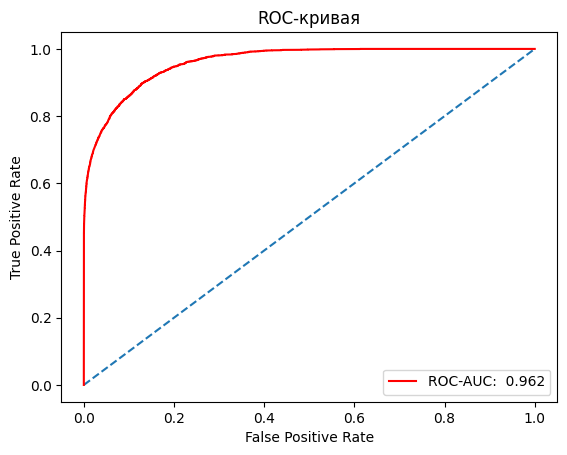

In [74]:
# Визуализируйте ROC-кривую и значение AUC на графике

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_lr_pipe, tpr_lr_pipe, c='r', label=f'ROC-AUC: {auc_lr_pipe: .3f}')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [75]:
# Для трех порогов классификации для модели lr_pipe на тестовой выборке
# рассчитайте и сравните значения метрик: precision, recall, accuracy, f1

thresholds = [0.25, 0.5, 0.75]

for threshold in thresholds:
  y_pred = (y_test_proba_lr_pipe > threshold).astype(int)
  print(classification_report(y_pipe_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     36593
           1       0.66      0.75      0.70      3400

    accuracy                           0.95     39993
   macro avg       0.82      0.86      0.83     39993
weighted avg       0.95      0.95      0.95     39993

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     36593
           1       0.87      0.62      0.73      3400

    accuracy                           0.96     39993
   macro avg       0.92      0.81      0.85     39993
weighted avg       0.96      0.96      0.96     39993

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     36593
           1       0.98      0.50      0.66      3400

    accuracy                           0.96     39993
   macro avg       0.97      0.75      0.82     39993
weighted avg       0.96      0.96      0.95     39993



In [76]:
# На отрезке [0, 1] найдите такое значение порога классификации, при котором метрика f1 будет принимать максимальное значение на тестовой выборке
# Шаг поиска — 0.001

step = 0.001

thresholds = np.linspace(0, 1, int(1/0.001+1))
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_test_proba_lr_pipe > threshold).astype(int)
    f1 = f1_score(y_pipe_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

In [77]:
best_f1, best_threshold

(0.7309036445332002, np.float64(0.454))

### **Коэффициент Джини**

**Коэффициент Джини (Gini)** — это метрика оценки качества моделей бинарной классификации, которая представляет собой линейное преобразование метрики AUC (Area Under the ROC Curve):

$$\text{Gini}=2 \times \text{AUC}−1$$

Значение Gini изменяется от 0 (отсутствие разделяющей способности) до 1 (идеальная модель), что позволяет интерпретировать Gini как меру корреляции между предсказанными вероятностями и истинными метками класса.

### ***Задание 9***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обученную модель `lr_pipe` из задания 6.

* Тестовую выборку из задания 6: `X_pipe_test`, `y_pipe_test`.

Реализуем две простые функции (модели) для предсказания вероятностей целевого класса в тестовой выборке:

* `random_uniform` — функция (модель), предсказывающая вероятности случайно из равномерного распределения.

* `linear_hba1c` — функция (модель), предсказывающая вероятности с помощью линейного преобразования (стандартизации) значений фактора HbA1c_level.

На тестовой выборке сравните точность прогноза модели `lr_pipe` и функций (моделей) `random_uniform` и `linear_hba1c`, построив ROC-кривую и рассчитав значения метрики AUC и коэффициента Gini.

In [78]:
# Предскажите вероятности целевого класса в тестовой выборке с помощью random_uniform
# Не забудьте зафиксировать RANDOM_STATE

def random_uniform(N, random_state=None):
    """
    Возвращает случайный прогноз вероятностей целевого класса из равномерного распределения.

    Аргументы:
        N (int): Длина вектора прогноза вероятностей целевого класса.
        random_state (int): Параметр, фиксирующий случайное состояние результата выполнения функции. По умолчанию не используется (None).

    Возвращает:
        numpy.ndarray: Предсказанные вероятности целевого класса.
    """
    rng = np.random.RandomState(random_state)
    return rng.uniform(0, 1, N)

y_test_proba_random_uniform = random_uniform(len(y_pipe_test), RANDOM_STATE)

In [79]:
# Предскажите вероятности целевого класса в тестовой выборке с помощью linear_hba1c

def linear_hba1c(hba1c_level):
    """
    Возвращает прогноз вероятностей целевого класса с помощью линейного преобразования (стандартизации) значений фактора HbA1c_level.

    Аргументы:
        hba1c_level (numpy.ndarray): Вектор значений фактора HbA1c_level в тестовой выборке.

    Возвращает:
        numpy.ndarray: Предсказанные вероятности целевого класса.
    """
    return (hba1c_level - hba1c_level.min()) / (hba1c_level.max() - hba1c_level.min())

y_test_proba_linear_hba1c = linear_hba1c(X_pipe_test['HbA1c_level'])

In [80]:
# Дополните функцию gini

def gini(y_true, y_score):
    """
    Возвращает значение коэффициента Gini для предсказанных вероятностей.

    Аргументы:
        y_true (numpy.ndarray): Истинные значения целевой переменной.
        y_score (numpy.ndarray): Предсказанные вероятности целевого класса.

    Возвращает:
        float: Значение коэффициента Gini для предсказанных вероятностей.
    """
    return 2 * roc_auc_score(y_true, y_score) - 1

In [81]:
# Постройте ROC-кривые для random_uniform и linear_hba1c на тестовой выборке

fpr_random_uniform, tpr_random_uniform, _ = roc_curve(y_pipe_test, y_test_proba_random_uniform)
fpr_linear_hba1c, tpr_linear_hba1c, _ = roc_curve(y_pipe_test, y_test_proba_linear_hba1c)

In [82]:
# Рассчитайте метрику AUC для random_uniform и linear_hba1c на тестовой выборке

auc_random_uniform = roc_auc_score(y_pipe_test, y_test_proba_random_uniform)
auc_linear_hba1c = roc_auc_score(y_pipe_test, y_test_proba_linear_hba1c)

In [83]:
# Рассчитайте коэффициент Gini для lr_pipe, random_uniform и linear_hba1c на тестовой выборке

gini_lr_pipe = gini(y_pipe_test, lr_pipe.predict_proba(X_pipe_test)[:, 1])
gini_random_uniform = gini(y_pipe_test, y_test_proba_random_uniform)
gini_linear_hba1c = gini(y_pipe_test, y_test_proba_linear_hba1c)

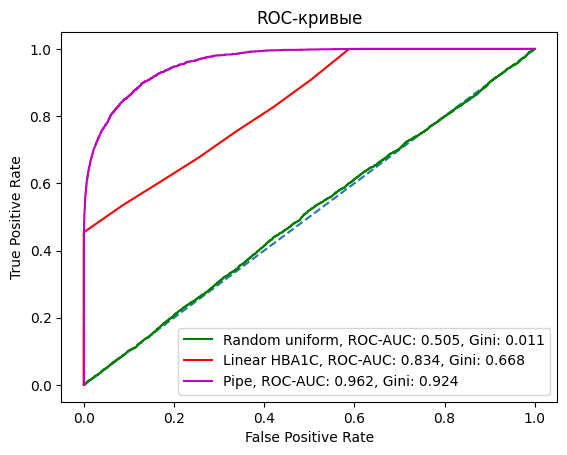

In [84]:
# Визуализируйте ROC-кривые и сравните значения AUC и Gini для трех моделей

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_random_uniform, tpr_random_uniform, c='g', label=f'Random uniform, ROC-AUC: {auc_random_uniform:.3f}, Gini: {gini_random_uniform:.3f}')
plt.plot(fpr_linear_hba1c, tpr_linear_hba1c, c='r', label=f'Linear HBA1C, ROC-AUC: {auc_linear_hba1c:.3f}, Gini: {gini_linear_hba1c:.3f}')
plt.plot(fpr_lr_pipe, tpr_lr_pipe, c='m', label=f'Pipe, ROC-AUC: {auc_lr_pipe:.3f}, Gini: {gini_lr_pipe:.3f}')
plt.title('ROC-кривые')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()